<a 
href="https://colab.research.google.com/github/adilo231/Python-for-machine-learning/blob/main/Chap -5- Demarche De datascientist/3- Modelisation.ipynb" 
target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
data = pd.read_excel('Datasets/dataset.xlsx')
df = data.copy()


# PRE-PROCESSING

In [52]:
df = data.copy()


## Création des sous-ensembles (suite au EDA)

In [53]:
missing_rate = df.isna().sum()/df.shape[0]

In [54]:
blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])

In [8]:
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [55]:
df = df[key_columns + blood_columns + viral_columns]


## TrainTest - Nettoyage - Encodage

In [9]:
from sklearn.model_selection import train_test_split

In [56]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [57]:
trainset['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [58]:
testset['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

In [39]:
def encodage(df):
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
        
    return df

In [40]:
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    return df

In [41]:
def imputation(df):
    #df['is na'] = (df['Parainfluenza 3'].isna()) | (df['Leukocytes'].isna())
    #df = df.fillna(-999)
    df = df.dropna(axis=0)
    return  df

In [59]:
def preprocessing(df):
    
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)
   
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']
    
    print(y.value_counts())
    
    return X, y

In [60]:
X_train, y_train = preprocessing(trainset)
print(X_train.shape, y_train.shape)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
(487, 16) (487,)


/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-40-61e0718b463d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['est malade'] = df[viral_columns].sum(axis=1) >= 1


In [61]:
X_test, y_test = preprocessing(testset)
print(X_test.shape, y_test.shape)

0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
(111, 16) (111,)


/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-40-61e0718b463d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['est malade'] = df[viral_columns].sum(axis=1) >= 1


## Procédure d'évaluation

In [19]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [20]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    

## Modellisation

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [22]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [23]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [24]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111

AdaBoost
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

SVM
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71  

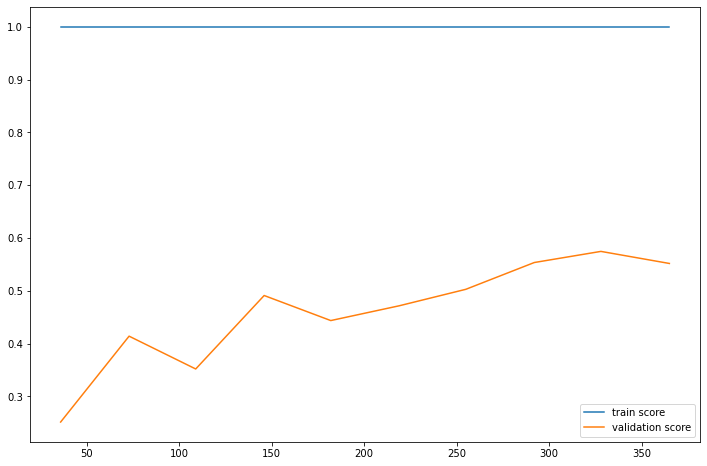

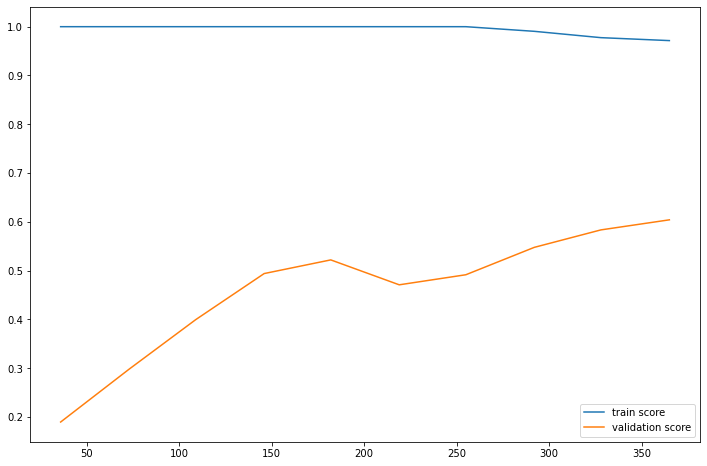

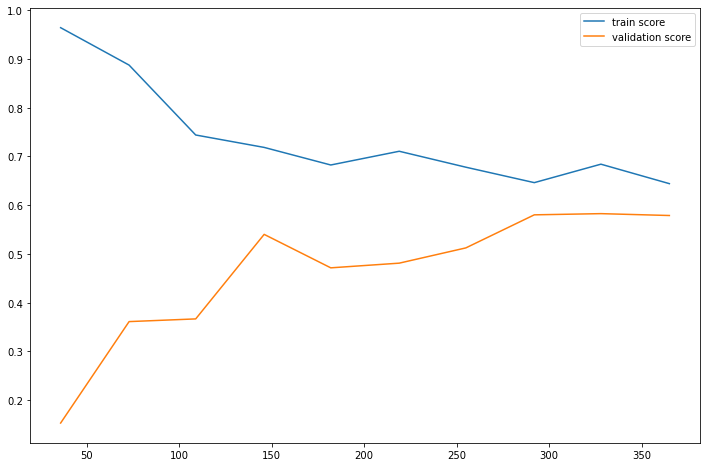

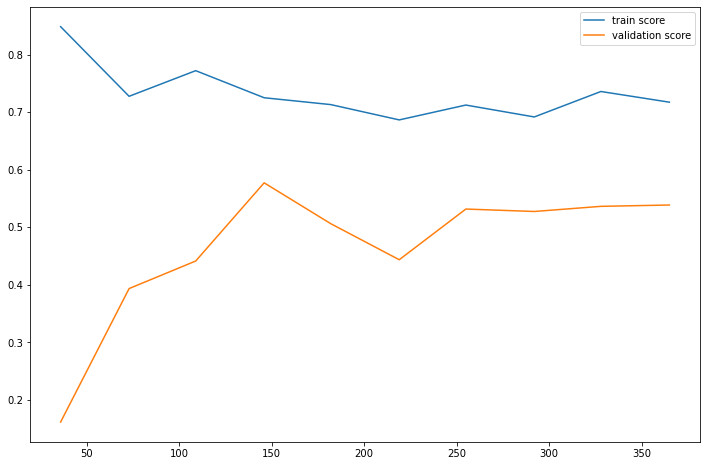

In [62]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

## OPTIMISATION

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [32]:
SVM

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('polynomialfeatures',
                                  PolynomialFeatures(degree=2,
                                                     include_bias=False,
                                                     interaction_only=False,
                                                     order='C')),
                                 ('selectkbest',
                                  SelectKBest(k=10,
                                              score_func=<function f_classif at 0x7f453d76d158>))],
                          verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel

In [ ]:
hyper_params = {'svc__gamma':[1e-3, 1e-4, 0.0005],
                'svc__C':[1, 10, 100, 1000, 3000], 
               'pipeline__polynomialfeatures__degree':[2, 3],
               'pipeline__selectkbest__k': range(45, 60)}

In [34]:
grid = RandomizedSearchCV(SVM, hyper_params, scoring='recall', cv=4,
                          n_iter=40)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__gamma': 0.0005, 'svc__C': 1000, 'pipeline__selectkbest__k': 53, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        95
           1       0.62      0.50      0.55        16

    accuracy                           0.88       111
   macro avg       0.77      0.72      0.74       111
weighted avg       0.87      0.88      0.88       111



[[90  5]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        95
           1       0.62      0.50      0.55        16

    accuracy                           0.88       111
   macro avg       0.77      0.72      0.74       111
weighted avg       0.87      0.88      0.88       111



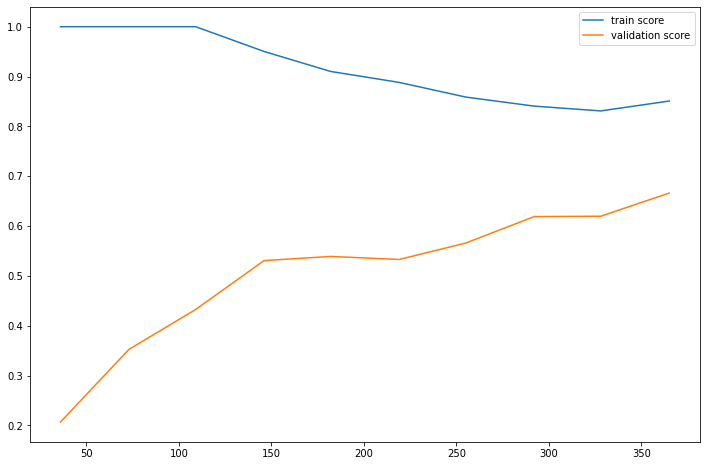

In [35]:
evaluation(grid.best_estimator_)

## Precision Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

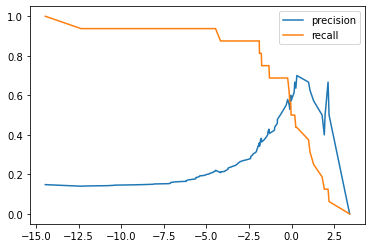

In [38]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [ ]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

In [ ]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-1)

In [ ]:
from sklearn.metrics import recall_score

In [42]:
f1_score(y_test, y_pred)

0.5365853658536586

In [43]:
recall_score(y_test, y_pred)

0.6875